In [14]:
using Distributions, Plots, RCall, StatsPlots, StatsBase
using SymPy
pyplot()

┌ Info: Recompiling stale cache file /home/davi/.julia/compiled/v1.0/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1190


Plots.PyPlotBackend()

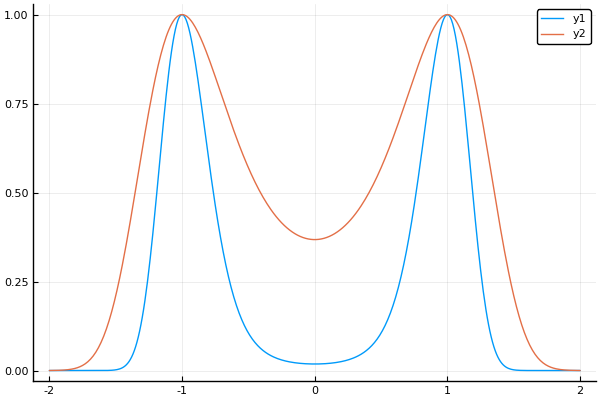

In [40]:
U(gam,x) =  gam*(x*x -1)*(x*x -1)
Temper(gam,x) = exp(-U(gam,x))
x = collect(-2:0.01:2);
plot(x ,Temper.(4,x))
plot!(x,Temper.(1,x))

In [68]:
temps  = 2 .^(0:3)
iters  = 1e5
function Chain(target, tune=0.1, init=1)
    x = init
    xvec = iters
    for i = 1:iters
        can = x + rand(Normal(0,tune))
        logA = target(x) - target(can)
    end
end

Chain (generic function with 4 methods)

In [3]:
chain=function(target,tune=0.1,init=1)
{
  x=init
  xvec=numeric(iters)
  for (i in 1:iters) {
    can=x+rnorm(1,0,tune)
    logA=target(x)-target(can)
    if (log(runif(1))<logA)
      x=can
    xvec[i]=x
  }
  xvec
}
R"""
# temper.R
# functions for messing around with tempering MCMC
 
U=function(gam,x)
{
  gam*(x*x-1)*(x*x-1)
}
 
curried=function(gam)
{
  #gam
  message(paste("Returning a function for gamma =",gam))
  function(x) U(gam,x)
}
U4=curried(4)
 
op=par(mfrow=c(2,1))
curve(U4(x),-2,2,main="Potential function, U(x)")
curve(exp(-U4(x)),-2,2,main="Unnormalised density function, exp(-U(x))")
par(op)
 
# global settings
temps=2^(0:3)
iters=1e5
 
# First look at some independent chains
chain=function(target,tune=0.1,init=1)
{
  x=init
  xvec=numeric(iters)
  for (i in 1:iters) {
    can=x+rnorm(1,0,tune)
    logA=target(x)-target(can)
    if (log(runif(1))<logA)
      x=can
    xvec[i]=x
  }
  xvec
}
 
mat=sapply(lapply(temps,curried),chain)
colnames(mat)=paste("gamma=",temps,sep="")
 
require(smfsb)
mcmcSummary(mat,rows=length(temps))
 
# Next, let's generate 5 chains at once...
chains=function(pot=U, tune=0.1, init=1)
{
  x=rep(init,length(temps))
  xmat=matrix(0,iters,length(temps))
  for (i in 1:iters) {
    can=x+rnorm(length(temps),0,tune)
    logA=unlist(Map(pot,temps,x))-unlist(Map(pot,temps,can))
    accept=(log(runif(length(temps)))<logA)
    x[accept]=can[accept]
    xmat[i,]=x
  }
  colnames(xmat)=paste("gamma=",temps,sep="")
  xmat
}
 
mcmcSummary(chains(),rows=length(temps))
 
# Next let's couple the chains...
chains=function(pot=U, tune=0.1, init=1)
{
  x=rep(init,length(temps))
  xmat=matrix(0,iters,length(temps))
  for (i in 1:iters) {
    can=x+rnorm(length(temps),0,tune)
    logA=unlist(Map(pot,temps,x))-unlist(Map(pot,temps,can))
    accept=(log(runif(length(temps)))<logA)
    x[accept]=can[accept]
    # now the coupling update
    swap=sample(1:length(temps),2)
    logA=pot(temps[swap[1]],x[swap[1]])+pot(temps[swap[2]],x[swap[2]])-
            pot(temps[swap[1]],x[swap[2]])-pot(temps[swap[2]],x[swap[1]])
    if (log(runif(1))<logA)
      x[swap]=rev(x[swap])
    # end of the coupling update
    xmat[i,]=x
  }
  colnames(xmat)=paste("gamma=",temps,sep="")
  xmat
}
 
mcmcSummary(chains(),rows=length(temps))
 
# eof
"""

┌ Warning: RCall.jl: Returning a function for gamma = 4
└ @ RCall /home/davi/.julia/packages/RCall/g7dhB/src/io.jl:113
┌ Warning: RCall.jl: Returning a function for gamma = 1
│ Returning a function for gamma = 2
│ Returning a function for gamma = 4
│ Returning a function for gamma = 8
└ @ RCall /home/davi/.julia/packages/RCall/g7dhB/src/io.jl:113
┌ Warning: RCall.jl: Loading required package: smfsb
│ Warning in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE,  :
│   there is no package called ‘smfsb’
└ @ RCall /home/davi/.julia/packages/RCall/g7dhB/src/io.jl:113


RCall.REvalError: REvalError: Error in mcmcSummary(mat, rows = length(temps)) : 
  could not find function "mcmcSummary"